In [92]:
import os
import json
import uuid
import numpy as np
import pandas as pd
from pydub import AudioSegment
import librosa

import torch
import torchaudio
from torchvision.models import resnet18
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
from torchsummary import summary

In [93]:
active_slot_duration = 5 # in sec
need_complete_audio = False
filter_label = "FIMO" # FIMO, RP, Deep, or empty
audio_sample_duration = active_slot_duration

if need_complete_audio:
    print("No need to split, just add padding")
    if (len(filter_label)):
        if filter_label == "FIMO":
            audio_sample_duration = 13
        elif filter_label == "RP":
            audio_sample_duration = 30
        elif filter_label == "Deep":
            audio_sample_duration = 12
    else:
        audio_sample_duration = active_slot_duration
else:
    print("split into slots, and add padding")
    audio_sample_duration = active_slot_duration

if (len(filter_label)):
    print("some")
else:
    print("noting")

print(f"final audio sample duration: {audio_sample_duration}")

split into slots, and add padding
some
final audio sample duration: 5


In [94]:
def determine_is_stridor_and_phonatory(name, folder_path, patient_status_df):
    """
    Determine if the path should be marked as stridor and phonatory based on the folder structure and excel sheet.
    """
    for part in folder_path.split(os.sep):
        if part.upper() in ["CONTROL", "CONTROLS"]:
            return "No-Stridor", "Non-Phonatory", "No-Stridor"  # is_stridor, is_phonatory, status

    # Extract patient code from the name
    if name.startswith("Patient "):
        patient_code = int(name.split(" ")[1])
        if patient_code in patient_status_df['Code'].values:
            status = patient_status_df[patient_status_df['Code'] == patient_code]['Status'].values[0]
            if status == "No-Stridor":
                return "No-Stridor", "Non-Phonatory", "No-Stridor"  # is_stridor, is_phonatory, status
            elif status == "Phonatory":
                return "Stridor", "Phonatory", "Phonatory"  # is_stridor, is_phonatory, status
            elif status == "Non-Phonatory":
                return "Stridor", "Non-Phonatory", "Non-Phonatory"  # is_stridor, is_phonatory, status
    
    return 0, 0, 0  # Default to non-stridor if not found

def get_audio_duration(file_path):
    """
    Get the duration of the audio file in seconds.
    """
    audio = AudioSegment.from_wav(file_path)
    return len(audio) / 1000  # Convert milliseconds to seconds

def load_audio(file_path):
    """
    Load the audio file.
    """
    y, sr = librosa.load(file_path)
    return y, sr

def compute_short_time_energy(y, frame_size=1024, hop_length=512):
    """
    Compute the short-time energy of the audio signal.
    """
    energy = np.array([
        np.sum(np.square(y[i:i+frame_size]))
        for i in range(0, len(y), hop_length)
    ])
    return energy

def find_most_active_timeframe(y, sr, hop_length, total_duration, slot_duration):
    """
    Find the most active timeframe in the audio signal and break it into slots.
    """
    frame_duration = int(slot_duration * sr / hop_length)
    total_frames = int(total_duration * sr / hop_length)
    energy = compute_short_time_energy(y, frame_size=hop_length, hop_length=hop_length)
    
    # Find the most active timeframe
    active_start_frame = np.argmax(np.convolve(energy, np.ones(total_frames), mode='valid'))
    active_start_time = (active_start_frame * hop_length) / sr
    active_end_time = active_start_time + total_duration

    # Break the active timeframe into slots
    slots = []
    for i in range(total_frames // frame_duration):
        slot_start_time = active_start_time + i * slot_duration
        slot_end_time = slot_start_time + slot_duration
        slots.append({"start_time": slot_start_time, "end_time": slot_end_time})
    
    return slots

def generate_recording_objects(root_path, patient_status_df):
    recordings = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(root_path):
        # Check if there are wav files in the current directory
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            # Get the parent folder name
            parent_folder = os.path.basename(root)
            
            for wav_file in wav_files:
                if parent_folder in ["Patient 1", "Patient 5", "Patient 10"]:
                    # print(f"parent_folder: {parent_folder}")
                    continue
                
                # Generate a unique ID for each player-session-recording combination
                uid = str(uuid.uuid4())
                # Extract the recording label (base name without extension)
                recording_label = os.path.splitext(wav_file)[0]
                # Get the full path of the wav file
                file_path = os.path.join(root, wav_file)
                # Get the duration of the audio file
                duration = get_audio_duration(file_path)

               
                
                # # Load the audio file and compute its short-time energy
                # y, sr = load_audio(file_path)
                # slots = find_most_active_timeframe(y, sr, hop_length=512, total_duration=total_duration, slot_duration=audio_sample_duration)
                
                # Determine is_stridor and is_phonatory from the folder structure and Excel sheet
                stridor_status, phonatory_status, status = determine_is_stridor_and_phonatory(parent_folder, root, patient_status_df)
                
                # # Calculate the number of slots and their duration
                # num_slots = duration // 3
                # if num_slots == 0:
                #     continue  # Skip recordings that are too short
                # total_duration = num_slots * 3
                
                # Create the entry for the current recording
                entry = {
                    "uid": uid,
                    "recording_id": uid,
                    "name": parent_folder,
                    "recording": file_path,  # Include the full path
                    "recording_label": recording_label,
                    "stridor_status": stridor_status,
                    "phonatory_status": phonatory_status,
                    "status": status,
                    "duration": duration,
                    # "recording_slots": slots
                }
                recordings.append(entry)
                
    return recordings

def save_to_csv(recordings, output_csv):
    # Flatten the recording slots for CSV
    flattened_data = []
    for record in recordings:
        base_data = {key: record[key] for key in record if key != 'recording_slots'}
        for slot in record['recording_slots']:
            slot_data = base_data.copy()
            slot_data.update(slot)
            flattened_data.append(slot_data)
    
    df = pd.DataFrame(flattened_data)
    df.to_csv(output_csv, index=False)

def save_to_json(recordings, output_json):
    with open(output_json, 'w') as json_file:
        json.dump(recordings, json_file, indent=4)

def count_samples(recordings):
    no_stridor_count = 0
    phonatory_count = 0
    non_phonatory_count = 0

    for record in recordings:
        if record['status'] == "No-Stridor":
            no_stridor_count += 1
        elif record['status'] == "Phonatory":
            phonatory_count += 1
        elif record['status'] == "Non-Phonatory":
            non_phonatory_count += 1
    
    return no_stridor_count, phonatory_count, non_phonatory_count

In [95]:
# Usage
root_path = 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files'  # Replace with the actual path to your folders
excel_path = 'C:\\Users\\namac\\Studies\\B2AI\\Stridor_Labels.xlsx'  # Replace with the actual path to your Excel file
output_csv = 'rec_6_time.csv'  # Desired output CSV file name
output_json = 'rec_6_time.json'  # Desired output JSON file name

# Read the Excel file
patient_status_df = pd.read_excel(excel_path)

recordings = generate_recording_objects(root_path, patient_status_df)
print(f"Total samples: {len(recordings)}")

# Uncomment the following lines to save to CSV
# save_to_csv(recordings, output_csv)
# print(f"Recording objects have been saved to {output_csv}")

# Uncomment the following lines to save to JSON
# save_to_json(recordings, output_json)
# print(f"Recording objects have been saved to {output_json}")

# Count the samples
no_stridor_count, phonatory_count, non_phonatory_count = count_samples(recordings)
print(f"No-Stridor samples: {no_stridor_count}")
print(f"Phonatory samples: {phonatory_count}")
print(f"Non-Phonatory samples: {non_phonatory_count}")

Total samples: 700
No-Stridor samples: 340
Phonatory samples: 89
Non-Phonatory samples: 261


In [96]:
def filter_recordings_by_label(data, label_prefix):
    """
    Filter recordings to only include those with recording_label starting with the specified prefix.
    Exclude specific labels for certain prefixes.
    Comparisons are case insensitive.
    """
    # Define exclusions for each prefix
    exclude_labels = {
        "FIMO": ["FIMOcricoid", "FIMOthyroid", "FIMOC", "FIMOT"],
        "RP": ["RPC", "RPT", "RPcricoid", "RPcriocid", "RPthyroid"]
    }

    # Convert prefix to lower case for case insensitive comparison
    label_prefix_lower = label_prefix.lower()
    
    # print(f"label_prefix_lower: {label_prefix_lower}")

    filtered_data = []
    for recording in data:
        # Get the recording label in lower case
        recording_label_lower = recording['recording_label'].lower()
        # print(f"recording_label_lower: {recording_label_lower}")
        
        # Check if the recording label starts with the given prefix
        if recording_label_lower.startswith(label_prefix_lower):
            # Check for exclusions
            if label_prefix in exclude_labels:
                if recording_label_lower in map(str.lower, exclude_labels[label_prefix]):
                    continue
            filtered_data.append(recording)

    return filtered_data


In [97]:
data = recordings.copy()
print(f"data count: {len(data)}")

# Filter recordings
if (len(filter_label)):
    filtered_data = filter_recordings_by_label(data, filter_label)
    data = filtered_data


print(f"filtered recordings count: {len(data)}")
print(f"filtered recordings: {data}")

data count: 700
filtered recordings count: 110
filtered recordings: [{'uid': '3e734284-411f-4731-89e3-6073fbd3b65c', 'recording_id': '3e734284-411f-4731-89e3-6073fbd3b65c', 'name': 'Patient 2', 'recording': 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 2\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'stridor_status': 'Stridor', 'phonatory_status': 'Non-Phonatory', 'status': 'Non-Phonatory', 'duration': 24.16}, {'uid': 'b41d1a09-333f-4fe3-a4d7-d5709951128e', 'recording_id': 'b41d1a09-333f-4fe3-a4d7-d5709951128e', 'name': 'Patient 3', 'recording': 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 3\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'stridor_status': 'Stridor', 'phonatory_status': 'Phonatory', 'status': 'Phonatory', 'duration': 13.05}, {'uid': 'bfd813d0-7b68-4147-8c5a-adb188e1922e', 'recording_id': 'bf

In [98]:
def compute_short_time_energy(y, frame_size=1024, hop_length=512):
    """
    Compute the short-time energy of the audio signal.
    """
    energy = torch.tensor([
        torch.sum(y[i:i+frame_size] ** 2)
        for i in range(0, len(y), hop_length)
    ])
    return energy

def get_most_active_segment(signal, sr, required_samples, hop_length=512):
    # Compute short-time energy
    frame_size = hop_length
    energy = compute_short_time_energy(signal, frame_size, hop_length)
    
    # Ensure required_samples is an integer
    required_samples = int(required_samples)
    
    # Find the most active segment
    active_start_frame = torch.argmax(torch.nn.functional.conv1d(
        energy.view(1, 1, -1), 
        torch.ones(1, 1, required_samples // hop_length)
    ))
    active_start_sample = active_start_frame * hop_length
    active_end_sample = active_start_sample + required_samples

    return signal[active_start_sample:active_end_sample]

In [99]:
from speechbrain.dataio.dataio import read_audio, read_audio_info

In [100]:
# Prepare audio dataset
audio_data = []
for entry in data:
    # Calculate the number of slots and their duration
    row = entry.copy()
    num_slots = int(entry["duration"] // audio_sample_duration)
    
    if num_slots == 0:
        # Audio signal is too short, do padding
        row["uid"] = str(uuid.uuid4())
        row["duration"] = audio_sample_duration
        
        audio = Audio.from_file(entry["recording"])
        audio = audio.to_16khz()
        
        # Pad the signal to match audio_sample_duration
        required_samples = audio_sample_duration * 16000  # 16 kHz sample rate
        padded_signal = torch.nn.functional.pad(audio.signal, (0, required_samples - audio.signal.size(0)), mode='constant', value=0)
        
        row["audio_sample"] = padded_signal
        
        audio_data.append(row)
    else:
        # Split into smaller parts
        print(" --- @ --- ")
        required_duration = audio_sample_duration * num_slots
        sr = 16000  # Assuming the sample rate is 16 kHz after resampling
        print(f"audio_sample_duration: {audio_sample_duration}")
        print(f"num_slots: {num_slots}")
        print(f"required_duration: {required_duration}")
        
        # Load the full audio signal
        audio = Audio.from_file(entry["recording"]).to_16khz()
        print(f"audio: {audio}")
        y = audio.signal
        print(f"y: {y}")
        y = y.squeeze(1)  # Ensure the tensor has the correct dimensions
        print(f"y: {y}")
        
        # Get the most active audio signal part for the timeframe of required_duration
        required_samples = required_duration * sr
        active_segment = get_most_active_segment(y, sr, required_samples)
        print(f"active_segment: {active_segment}")
        
        # Split the active segment into smaller parts of audio_sample_duration
        segment_samples = audio_sample_duration * sr
        print(f"segment_samples: {segment_samples}")
        segments = [active_segment[i:i + segment_samples] for i in range(0, len(active_segment), segment_samples)]
        print(f"segments: {segments}")
        
        for i, segment in enumerate(segments):
            if segment.shape[0] < segment_samples:
                segment = torch.nn.functional.pad(segment, (0, segment_samples - segment.shape[0]), mode='constant', value=0)
            segment_audio = Audio(segment.unsqueeze(1), audio.sample_rate)
            segment_row = row.copy()
            segment_row["uid"] = f"{entry['uid']}-{i+1}"
            segment_row["duration"] = audio_sample_duration
            segment_row["audio_sample"] = segment_audio
            print(f'segment_row["audio_sample"]: {segment_row["audio_sample"]}')
            audio_data.append(segment_row)
            
        # # Split into smaller parts
        # print(" --- @ --- ")
        # required_duration = audio_sample_duration * num_slots
        # print(f"audio_sample_duration: {audio_sample_duration}")
        # print(f"num_slots: {num_slots}")
        # print(f"required_duration: {required_duration}")
        # sr = 16000  # Assuming the sample rate is 16 kHz after resampling
        
        # # Load the audio signal
        # y, _ = librosa.load(entry["recording"], sr=sr)
        
        # print(f"y: {y}")
        
        # # Get the most active audio signal part for the timeframe of required_duration
        # required_samples = required_duration * sr
        # active_segment = get_most_active_segment(y, sr, required_samples)
        
        # print(f"active_segment: {active_segment}")
        
        
        
        # # Split the active segment into smaller parts of audio_sample_duration
        # segment_samples = audio_sample_duration * sr
        # print(f"segment_samples: {segment_samples}")
        # segments = [active_segment[i:i + segment_samples] for i in range(0, len(active_segment), segment_samples)]
        # print(f"segments: {segments}")
        
        # for i, segment in enumerate(segments):
        #     segment_row = row.copy()
        #     segment_row["uid"] = f"{entry['uid']}-{i+1}"
        #     segment_row["duration"] = audio_sample_duration
        #     segment_row["audio_sample"] = torch.tensor(segment, dtype=torch.float32)
        #     print(f'segment_row["audio_sample"]: {segment_row["audio_sample"]}')
        #     audio_data.append(segment_row)

 --- @ --- 
audio_sample_duration: 5
num_slots: 4
required_duration: 20
audio: <b2aiprep.process.Audio object at 0x00000262AA4536E0>
y: tensor([[ 0.0016],
        [ 0.0119],
        [ 0.0128],
        ...,
        [-0.0088],
        [-0.0081],
        [-0.0076]])
y: tensor([ 0.0016,  0.0119,  0.0128,  ..., -0.0088, -0.0081, -0.0076])
active_segment: tensor([-0.0030,  0.0104,  0.0198,  ...,  0.0030, -0.0013,  0.0106])
segment_samples: 80000
segments: [tensor([-0.0030,  0.0104,  0.0198,  ..., -0.0058, -0.0064, -0.0066]), tensor([-0.0079, -0.0074, -0.0085,  ...,  0.0019, -0.0006, -0.0032]), tensor([-6.7376e-03,  8.5909e-05, -2.5173e-03,  ..., -2.5103e-03,
        -1.9346e-03, -1.4014e-03]), tensor([-0.0009, -0.0005, -0.0002,  ...,  0.0030, -0.0013,  0.0106])]
segment_row["audio_sample"]: <b2aiprep.process.Audio object at 0x00000262AA446CF0>
segment_row["audio_sample"]: <b2aiprep.process.Audio object at 0x00000262B10D7DA0>
segment_row["audio_sample"]: <b2aiprep.process.Audio object at 0x00

In [101]:
print(f"audio_data: {len(audio_data)}")

audio_data: 272


In [102]:
from sklearn.preprocessing import LabelEncoder

class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_column, num_classes):
        self.dataframe = dataframe.copy()  # Copy to avoid modifying the original DataFrame
        self.label_column = label_column
        self.num_classes = num_classes
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording_id', 'recording_label', 'recording', 'audio_sample', label_column]
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")
            
         # Store the unique labels and create a mapping
        self.unique_labels = list(self.dataframe[label_column].unique())
        self.label_to_index = {label: index for index, label in enumerate(self.unique_labels)}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}

        # Convert the label column to integer indices
        self.dataframe[label_column] = self.dataframe[label_column].map(self.label_to_index)

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.audio_samples = dataframe['audio_sample'].tolist()
        self.labels = self.dataframe[label_column].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()
        self.recording_ids = dataframe['recording_id'].tolist()
        # self.num_classes = len(self.unique_labels)
        print(f"self.num_classes: {self.num_classes}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_sample = self.audio_samples[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]
        
        # print("@@@")

        try:
            win_length = 30
            hop_length = 10
            nfft = 512
            features_specgram = specgram(audio_sample, win_length=win_length, hop_length=hop_length, n_fft=nfft)
            features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T

        except Exception as e:
            print(f"Error while converting audio signal with uid {uid}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # # Convert the label to a tensor
        # label = torch.tensor(label, dtype=torch.float32)
        
        # Convert the label to a one-hot encoded tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        label_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=self.num_classes).float()

        return {'uid': uid, 'signal': features_specgram, self.label_column: label_tensor, 'recording_label': recording_label}
    
    def decode_label(self, label_tensor):
        """
        Decode a one-hot or integer label tensor back to its original categorical label.
        """
        if label_tensor.dim() == 1 and label_tensor.size(0) == self.num_classes:
            # One-hot encoded tensor
            label_index = torch.argmax(label_tensor).item()
        elif label_tensor.dim() == 0:
            # Integer tensor
            label_index = label_tensor.item()
        else:
            raise ValueError("Unsupported label tensor format")
        
        return self.index_to_label[label_index]

In [103]:
import matplotlib.pyplot as plt
import IPython.display as ipd

def display_and_play_sample(audio_data, index):
    if index < 0 or index >= len(audio_data):
        print("Index out of range")
        return

    sample = audio_data[index]
    audio_signal = sample["audio_sample"].signal.squeeze().numpy()  # Extract signal from Audio object and convert to numpy array
    sample_rate = sample["audio_sample"].sample_rate  # Get the sample rate from the Audio object
    
    # Display details
    print(f"UID: {sample['uid']}")
    print(f"Recording ID: {sample['recording_id']}")
    print(f"Recording Label: {sample['recording_label']}")
    
    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(audio_signal)
    plt.title("Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Play audio
    ipd.display(ipd.Audio(audio_signal, rate=sample_rate))

UID: b41d1a09-333f-4fe3-a4d7-d5709951128e-1
Recording ID: b41d1a09-333f-4fe3-a4d7-d5709951128e
Recording Label: FIMO12inch


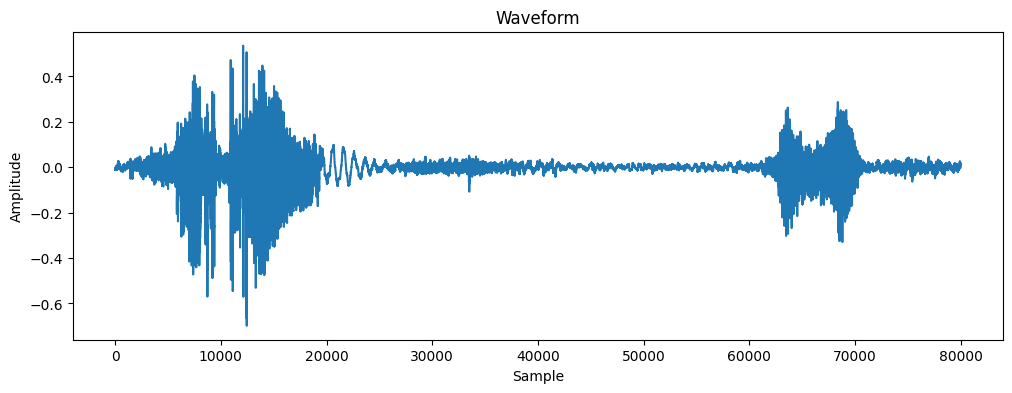

In [104]:
# Example usage
index = 4  # Replace with the desired sample index
display_and_play_sample(audio_data, index)

num_classes: 2
self.num_classes: 2
dataset: <__main__.MySpecgramDataset object at 0x00000262B0F8FBC0>
['FIMOiPad', 'FIMOAvid', 'FIMOiPad', 'FIMO12inch', 'FIMOiPad', 'FIMOiPad', 'FIMOiPad', 'FIMOavid'] tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
the shape is:  torch.Size([257, 501])


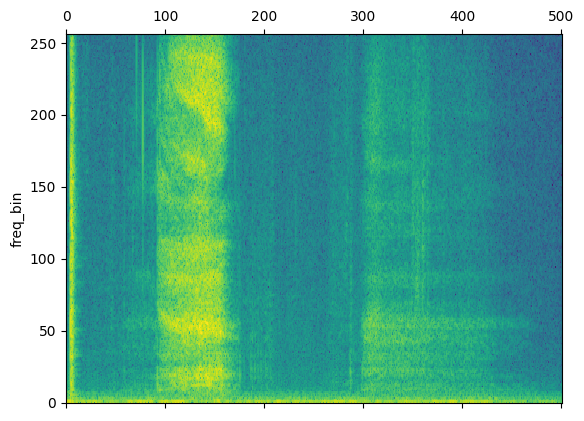

In [105]:
# convert into dataframe
df = pd.DataFrame(audio_data)
# print(f"df: {df}")
label_column = 'stridor_status'  # Or 'status', depending on your use case
num_classes = df[label_column].nunique()
print(f"num_classes: {num_classes}")

dataset = MySpecgramDataset(df, label_column, num_classes)
print(f"dataset: {dataset}")

# # Example: Iterate through the dataset
# for i in range(len(dataset)):
#     sample = dataset[i]
#     print(sample['recording_label'], sample[label_column])

# # Example: Decode a label
# sample_label = dataset[22][label_column]
# print(f"sample_label: {sample_label}")
# decoded_label = dataset.decode_label(sample_label)
# print(f"Original label: {decoded_label}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch['recording_label'], batch['stridor_status'])
    plot_spectrogram(batch['signal'][0])
    print("the shape is: ", batch['signal'][0].shape)
    break

In [106]:
cnn = resnet18('IMAGENET1K_V1')
cnn.fc = torch.nn.Linear(512, num_classes)
_ = summary(cnn, (3, 257, 301))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 129, 151]           9,408
       BatchNorm2d-2         [-1, 64, 129, 151]             128
              ReLU-3         [-1, 64, 129, 151]               0
         MaxPool2d-4           [-1, 64, 65, 76]               0
            Conv2d-5           [-1, 64, 65, 76]          36,864
       BatchNorm2d-6           [-1, 64, 65, 76]             128
              ReLU-7           [-1, 64, 65, 76]               0
            Conv2d-8           [-1, 64, 65, 76]          36,864
       BatchNorm2d-9           [-1, 64, 65, 76]             128
             ReLU-10           [-1, 64, 65, 76]               0
       BasicBlock-11           [-1, 64, 65, 76]               0
           Conv2d-12           [-1, 64, 65, 76]          36,864
      BatchNorm2d-13           [-1, 64, 65, 76]             128
             ReLU-14           [-1, 64,

In [107]:
# Function to evaluate the model
def eval(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            bs, h, w = batch['signal'].shape
            inputs = batch['signal'].unsqueeze(1).expand(bs, 3, h, w)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total_correct += (preds == torch.argmax(batch[label_column], 1)).sum().item()
            total_samples += bs
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(batch[label_column], 1).cpu().numpy())
    
    accuracy = total_correct / total_samples
    return accuracy, all_preds, all_labels	

# Training the model
num_epochs = 25
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    cnn.train()
    
    train_loss = 0
    total_train_samples = 0
    for batch in train_dataloader:
        bs, h, w = batch['signal'].shape
        inputs = batch['signal'].unsqueeze(1).expand(bs, 3, h, w)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, torch.argmax(batch[label_column], 1))
        train_loss += loss.item() * bs
        total_train_samples += bs
        loss.backward()
        optimizer.step()
    
    train_loss /= total_train_samples
    train_acc, _, _ = eval(cnn, train_dataloader)
    val_acc, _, _ = eval(cnn, val_dataloader)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}, Val ACC: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), './my_resnet_model.pth')
        print('Saved!')

Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Epoch: 1, Train Loss: 0.9181, Train ACC: 0.6406, Val ACC: 0.6296
Saved!
Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Epoch: 2, Train Loss: 0.5926, Train ACC: 0.6359, Val ACC: 0.5556
Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Error while converting audio signal with uid c0c12e79-6361-4863-a020-3042be259b43: 'Tensor' object has no attribute 'sample_rate'
Epoch: 3, Train Loss: 0.5482, Train ACC: 0.6452, Val ACC: 0.5926
Error while conver

In [108]:
# Load the best model and evaluate on the test set
cnn.load_state_dict(torch.load('./my_resnet_model.pth'))
test_acc, test_preds, test_labels = eval(cnn, test_dataloader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7857


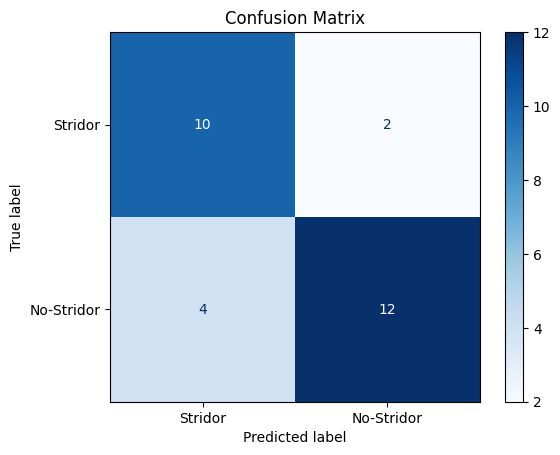

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()